# Lotka-Volterra

In [16]:
import numpy as np
from numpy import zeros, sqrt, ravel, array, vstack, r_, exp, pi, log, eye, isfinite, errstate, ones, hstack, diag
from numpy import linspace
from numpy.random import randn, default_rng, rand
from numpy.linalg import norm

from scipy.stats import lognorm as lognorm_dist
from scipy.stats import norm as ndist
from scipy.stats import multivariate_normal as MVN
from scipy.optimize import fsolve
from scipy.linalg import qr

from warnings import catch_warnings, filterwarnings

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

from autograd import jacobian
import autograd.numpy as anp

from tangential_hug_functions import HugTangentialMultivariate

In [17]:
# Settings
S  = 50     # Number of time points
δ  = 1      # Integrator step size
σr = 1
σf = 1
r0 = 100
f0 = 100
z = array([0.4, 0.005, 0.05, 0.001])

# Hyperparameters for prior
mi = -2
si = 1

# Dimensionality of ξ
d = 4 + 2*S

def one_at(index, length):
    """Creates a vector of zeros of length `length` with a 1 in position `index`."""
    out = zeros(length)
    out[index] = 1
    return out

# Lotka-Volterra Class

The main problem I had with Thug was that the $z$ parameter must be positive. However, updating the $z$ parameter via $z + (\delta/2)v$ can easily bring some of the components to be negative. For this reason, it is probably worth working with 
$$
\gamma = \log(z)
$$
because then $\gamma$ can take any values but $z = \exp(\gamma)$ will necessarily be positive. Recall that $Z = \exp(s_i U_1 + m_i)$ where $s_i=1$ and $m_i=-2$ and $U_1\sim\mathcal{N}(0, I_4)$. 

By definition of log-normal distribution we know that $\log(Z)$ is normally distributed. In our case, since we know the generating process is $\exp(s_i U_1 + m_i)$, we know that
$$
\log(Z) \sim \mathcal{N}(\mathbf{m}, \text{diag}(\mathbf{s}^2))
$$
where $\mathbf{m} = (m_i, m_i, m_i, m_i)$ and $\mathbf{s} = (s_i, s_i, s_i, s_i)$. Recall also that $u_2$ are standard normal random variables. So really, one could simply work with $\xi = [u_1, u_2]$ where
$$
U_1 = \frac{\log(Z) - m_i}{s_i} 
$$
and $U_1$ is also standard normal. The variable we would be working with then would be
$$
\xi = [u_1, u_2]
$$
rather than the old $\xi = [z, u_2]$. The prior for $\xi$ would simply be a $S+4$ dimensional standard multivariate gaussian.

In [18]:
class LotkaVolterra:
    def __init__(self, r0, f0, S, δ, σr, σf, mi, si, ϵ, kernel='normal', summary_stats=False):
        self.r0 = r0
        self.f0 = f0 
        self.S  = S
        self.δ  = δ
        self.σr = σr
        self.σf = σf
        self.mi = mi
        self.si = si  # Called `mi` and `si` to avoid `s` getting confused with `S`
        self.ϵ  = ϵ
        self.summary_stats = summary_stats # Determines whether output data is summery stats or actual data.
        # Choose correct function
        self.f = self.f_stats if summary_stats else self.f_nostats
        # If needed, store an instantiation of the jacobian for the summary statistics
        if summary_stats:
            self.Jss = jacobian(self.ss_autograd)
        # If using summary statistics, need to premultiply by Jss
        self.J = self.J_nostats
        if summary_stats:
            self.J = lambda ξ: self.Jss(self.f_nostats(ξ)) @ self.J_nostats(ξ)
        self.logkernel = self.log_normal_kernel if kernel == 'normal' else self.log_epanechnikov_kernel
        # parameter size and latent size
        self.u1_dim  = 4
        self.u2_dim = 2*self.S
        self.ξ_dim  = self.u1_dim + self.u2_dim
        self.y_dim  = self.u2_dim
        # Store autograd Jacobian
        self.Jacobian_instantiation = jacobian(self.f_autograd)
        
    def f_stats(self, ξ):
        """Function (u1, u2) ---> ss(y)."""
        return self.ss(self.f_nostats(ξ))
        
    def f_nostats(self, ξ):
        """ξ = (u1, u2) in Graham's paper notation."""
        u1, u2 = ξ[:self.u1_dim], ξ[self.u1_dim:]
        z      = exp(self.si*u1 + self.mi)
        assert (z >=0).all(), "Parameters must be positive."
        r, f = zeros(self.S + 1), zeros(self.S + 1)
        r[0], f[0] = self.r0, self.f0
        for s in range(self.S):
            r[s+1] = r[s] + self.δ*(z[0]*r[s] - z[1]*r[s]*f[s]) + sqrt(self.δ)*self.σr*u2[2*s]
            f[s+1] = f[s] + self.δ*(z[3]*r[s]*f[s] - z[2]*f[s]) + sqrt(self.δ)*self.σf*u2[2*s+1]
        return ravel([r[1:], f[1:]], 'F')
    
    def f_zu2(self, ξ_zu2):
        """Old f taking [z, u2] as input."""
        z, u2 = ξ_zu2[:self.u1_dim], ξ_zu2[self.u1_dim:]
        assert (z >=0).all(), "Parameters must be positive."
        r, f = zeros(self.S + 1), zeros(self.S + 1)
        r[0], f[0] = self.r0, self.f0
        for s in range(self.S):
            r[s+1] = r[s] + self.δ*(z[0]*r[s] - z[1]*r[s]*f[s]) + sqrt(self.δ)*self.σr*u2[2*s]
            f[s+1] = f[s] + self.δ*(z[3]*r[s]*f[s] - z[2]*f[s]) + sqrt(self.δ)*self.σf*u2[2*s+1]
        return ravel([r[1:], f[1:]], 'F')
    
    def parameter_prior(self, u1):
        """Prior distribution for u1. This is a product of 4 standard normals."""
        #return lognorm_dist.pdf(z, s=self.si, scale=exp(self.mi)).prod()
        return ndist.pdf(u1).prod()
    
    def parameter_logprior(self, u1):
        """Log-prior for u1."""
        #return lognorm_dist.logpdf(z, s=self.si, scale=exp(self.mi)).sum()
        return ndist.logpdf(u1).sum()
    
    def u2_logprior(self, u2):
        """Log prior for u2."""
        return ndist.logpdf(u2).sum()
    
    def logprior(self, ξ):
        """Log prior for ξ = (z, u2)."""
        return self.parameter_logprior(ξ[:self.u1_dim]) + self.u2_logprior(ξ[self.u1_dim:])
    
    def sample_u1(self):
        """Samples u1."""
        #return lognorm_dist.rvs(s=self.si, scale=exp(self.mi), size=self.z_dim)
        return ndist.rvs(size=self.u1_dim)
    
    def sample_u2(self):
        """Samples u2."""
        return ndist.rvs(size=self.u2_dim)
    
    def sample_prior(self):
        """Samples from prior of ξ = (u1, u2)."""
        u1 = self.sample_u1()
        u2 = self.sample_u2()
        return r_[u1, u2]
    
    def generate_data(self, z, seed=1234):
        """Generates data given z and a seed"""
        rng = default_rng(seed)
        u2  = rng.normal(size=self.u2_dim)
        u1  = (log(z) - self.mi) / self.si
        self.ξ_that_generated_data = r_[u1, u2]
        if self.summary_stats:
            self.ystar_before_ss = self.f_nostats(self.ξ_that_generated_data)
        return self.f(self.ξ_that_generated_data)
    
    def generate_z_from_u1(self, u1):
        """Generates parameter z from standard normal u1."""
        return exp(u1 * self.si + self.mi)
    
    def set_ystar(self, ystar):
        """Given a ystar, we set it as an attribute."""
        self.ystar = ystar
        
    def log_normal_kernel(self, ξ):
        """Log Gaussian kernel.
        For info on kernels see "Overview of ABC" in Handbook of ABC by Sisson."""
        if self.ystar is None:
            raise ValueError("Set the bloody ystar, you pig.")
        u = norm(self.f(ξ) - self.ystar)
        return -u**2/(2*(self.ϵ**2)) -0.5*log(2*pi*(self.ϵ**2))
    
    def log_epanechnikov_kernel(self, ξ):
        """Log Epanechnikov kernel applied to a xi, using observed data and provided tolerance epsilon."""
        if self.ystar is None:
            raise ValueError("Set the bloody ystar, you pig.")
        u = norm(self.f(ξ) - self.ystar)
        with errstate(divide='ignore'):
            return log((3*(1 - (u**2 / (self.ϵ**2))) / (4*self.ϵ)) * float(u <= self.ϵ))
        
    def log_abc_posterior(self, ξ):
        """Log ABC posterior over ξ = (z, u2)"""
        return self.logprior(ξ) + self.logkernel(ξ)
    
    def find_point_on_manifold(self, max_iter=1000, tol=1.49012e-08, use_jacobian=False):
        ##### M is the number of standard deviations from the mean that we use to check u2
        # try to find a point that makes the constraint function zero..?
        i = 0
        with catch_warnings():
            filterwarnings('error')
            while i <= max_iter:
                i += 1
                try: 
                    # Find z, using tecnique from Graham
#                   z  = self.generate_z_from_u1(randn(4)*0.1 - 4)
#                   u2 = randn(self.u2_dim)
#                   ξ_guess = r_[z, u2]
#                   ξ_guess = self.sample_prior()
#                   ξ_found = fsolve(lambda ξ: r_[self.f(ξ) - self.ystar, zeros(4)], ξ_guess, xtol=tol)
                    #z_init = self.generate_z_from_u1(randn(4)*0.1 - 4)
                    u1_init = randn(4)*0.1 - 4
                    #z_init = z
                    #ξ_init = self.ξ_that_generated_data + r_[zeros(self.z_dim), randn(self.u2_dim)*0.0001]
                    func = lambda u_: self.f_nostats(r_[u1_init, u_]) - self.ystar_before_ss
#                     if not self.summary_stats:
#                         func = lambda u_: self.f(r_[u1_init, u_]) - self.ystar
#                     else:
#                         func = lambda u_: r_[self.f(r_[u1_init, u_]) - self.ystar, zeros(self.u2_dim-9)]
                    #func = lambda ξ_: r_[self.f(ξ_) - self.ystar, zeros(self.z_dim)]
                    fprime = None
                    if use_jacobian:
                        fprime = lambda u_: self.J_nostats(r_[u1_init, u_])[:, 4:]
#                     if use_jacobian:
#                         fprime = lambda u_: LV.Jacobian_instantiation(r_[z_init, u_])[:, 4:]
#                     else:
#                         fprime = None
                    u2_found = fsolve(func, zeros(self.S*2), xtol=tol, fprime=fprime)
                    #u_found = fsolve(func, zeros(self.S*2), xtol=tol, fprime=fprime)
                    #ξ_found = fsolve(func, ξ_init, xtol=tol)
                    # To avoid u2 that give zero prior, check that all of them are within μ +- 2σ or something 
                    # like that. In our case u2 ~ N(0, self.u2_scale**2) hence we just want to check that its 
                    # between -2*self.u2_scale and +2*self.u2_scale
                    #if (-2*self.u2_scale <= u_found).all() and (u_found <= 2*self.u2_scale).all():
                    #    ξ_found = r_[z_init, u_found]
                    ξ_found = r_[u1_init, u2_found]
                    #if (-2*self.u2_scale <= ξ_found[self.z_dim:]).all() and (ξ_found[self.z_dim:] <= 2*self.u2_scale).all():
                    if not isfinite([self.log_abc_posterior(ξ_found)]):
                        pass
                    else:
                        return ξ_found
                        
                except RuntimeWarning:
                    continue
            raise ValueError("Couldn't find a point, try again.")
            
#     def J(self, ξ):
#         """Jacobian, naive implementation."""
#         # Prepare Jacobian
#         J = zeros((self.y_dim, self.ξ_dim))
#         # First transform ξ=(u1, u2) and grab z
#         z = exp(self.si*ξ[:self.u1_dim] + self.mi)
#         #print("Jacobian shape: ", J.shape)
#         # Compute dr1/dξ and df1/dξ
#         dr1_dξ = r_[[self.δ*self.r0, -self.δ*self.r0*self.f0, 0, 0, sqrt(self.δ)*self.σr], zeros(self.u2_dim-1)]
#         df1_dξ = r_[[0, 0, -self.δ*self.f0, self.δ*self.r0*self.f0, 0, sqrt(self.δ)*self.σf], zeros(self.u2_dim-2)]
#         # Store these two rows
#         J[0, :] = dr1_dξ
#         J[1, :] = df1_dξ
#         # Run the function
#         y = self.f(ξ)
#         r, f = y[::2], y[1::2]
#         #print("Data shape: ", y.shape, "r shape: ", r.shape, "f shape: ", f.shape)
#         for s in range(2, self.y_dim-1):
#             # Derivative of r_s with respect to ξ=(z, u2)
#             #print("Iteration s=", s, " Filling J[{}, :]".format(s), " Using J[{}, :]".format(s-2), " Using r[{}] and f[{}]".format(s//2 - 1, s//2 - 1))
#             J[s, :] = J[s-2, :] +\
#                     self.δ*(r[s//2 - 1]*one_at(0, self.ξ_dim) + z[0]*J[s-2, :]) -\
#                     self.δ*(r[s//2 - 1]*f[s//2 - 1]*one_at(1, self.ξ_dim) + z[1]*f[s//2 - 1]*J[s-2, :] + z[1]*r[s//2 - 1]*J[s-1, :]) +\
#                     sqrt(self.δ)*self.σr*one_at(self.u1_dim+s, self.ξ_dim)
#             # Derivative of f_s with respect to ξ=(z, u2)
#             J[s+1, :] = J[s-1, :] + self.δ*(one_at(3, self.ξ_dim)*r[s//2 - 1]*f[s//2 - 1] + z[3]*f[s//2 - 1]*J[s-2, :] + z[3]*r[s//2 - 1]*J[s-1, :]) - self.δ*(one_at(2, self.ξ_dim)*f[s//2 - 1] + z[2]*J[s-1, :]) + sqrt(self.δ)*self.σf*one_at(self.u1_dim + s + 1, self.ξ_dim)
#         # Jacobian of transformation (z, u_2) -> (u_1, u2)
#         J_transf = diag(self.si*exp(self.si*ξ[:self.u1_dim] + self.mi))
#         J_transf = fill_with_identitity_diag_and_zero_off_diags(J_transf, self.u2_dim)
#         return J @ J_transf
    
#     def Jacobian_zu2(self, ξ_zu2):
#         """Computes the Jacobian of the original transformation f_old:(z, u2) -> y."""
#         δ, r0, f0, σr, σf, ξdim, ydim = self.δ, self.r0, self.f0, self.σr, self.σf, self.ξ_dim, self.y_dim
#         u1dim, u2dim, S = self.u1_dim, self.u2_dim, self.S
#         J = zeros((ydim, ξdim))                  # Prepare Jacobian
#         z1, z2, z3, z4 = ξ_zu2[:u1dim]
#         dr1dξ = r_[δ*r0, -δ*r0*f0, 0, 0, sqrt(δ)*σr, zeros(u2dim-1)]
#         df1dξ = r_[0, 0, -δ*f0, δ*r0*f0, 0, sqrt(δ)*σf, zeros(u2dim-2)]
#         J[0, :] = dr1dξ
#         J[1, :] = df1dξ
#         y = self.f_zu2(ξ_zu2)
#         r, f = r_[r0, y[::2]], r_[f0, y[1::2]]
#         oneat = lambda index: one_at(index, length=ξdim)
#         # Populate rows from 2:2S
#         for s in range(1, S):
#             # drs / dξ
#             J[2*s, :]   = J[2*s-2, :] + δ*(oneat(0)*r[s] + z1*J[2*s-2, :] - oneat(1)*r[s]*f[s] - z2*f[s]*J[2*s-2, :] - z2*r[s]*J[2*s-1,:]) + sqrt(δ)*σr*oneat(2*s+2)
#             # dfs / dξ
#             J[2*s+1, :] = J[2*s-1, :] + δ*(oneat(3)*r[s]*f[s] + z4*f[s]*J[2*s-2, :] + z4*r[s]*J[2*s-1, :] - oneat(2)*f[s] - z3*J[2*s-1,:]) + sqrt(δ)*σf*oneat(2*s+3)
#         return J
    
    def J_nostats(self, ξ):
        """Computes Jacobian of f:[u1, u2] ---> y"""
        # Preliminary set up
        δ, r0, f0, σr, σf, ξdim, ydim = self.δ, self.r0, self.f0, self.σr, self.σf, self.ξ_dim, self.y_dim
        mi, si, u1dim, u2dim, S = self.mi, self.si, self.u1_dim, self.u2_dim, self.S
        J = zeros((ydim, ξdim))                  # Prepare Jacobian
        z1, z2, z3, z4 = exp(si*ξ[:u1dim] + mi)  # Transform u1 -> z
        u1 = ξ[:u1dim]
        # Compute first round of derivatives
        dr1dξ = r_[δ*r0, -δ*r0*f0, 0, 0, sqrt(δ)*σr, zeros(u2dim-1)]
        df1dξ = r_[0, 0, -δ*f0, δ*r0*f0, 0, sqrt(δ)*σf, zeros(u2dim-2)]
        J[0, :] = dr1dξ
        J[1, :] = df1dξ
        # Generate data corresponding to ξ
        y = self.f_nostats(ξ)
        # Store r=[r0, r1, ..., rS] and f=[f0, f1, ..., fS]
        r, f = r_[r0, y[::2]], r_[f0, y[1::2]]
        oneat = lambda index: one_at(index, length=ξdim)
        # Populate rows from 2:2S
        for s in range(1, S):
            # drs / dξ
            J[2*s, :]   = J[2*s-2, :] + δ*(oneat(0)*r[s] + z1*J[2*s-2, :] - oneat(1)*r[s]*f[s] - z2*f[s]*J[2*s-2, :] - z2*r[s]*J[2*s-1,:]) + sqrt(δ)*σr*oneat(2*s+4)
            # dfs / dξ
            J[2*s+1, :] = J[2*s-1, :] + δ*(oneat(3)*r[s]*f[s] + z4*f[s]*J[2*s-2, :] + z4*r[s]*J[2*s-1, :] - oneat(2)*f[s] - z3*J[2*s-1,:]) + sqrt(δ)*σf*oneat(2*s+5)
        # Recall f = f_old \circ u1_to_z hence need to generate this jacobian and multiply by it
        Jtransf_diagonal = r_[si*exp(si*u1 + mi), ones(u2dim)]
        Jtransf          = diag(Jtransf_diagonal)
        return J @ Jtransf
    
    def ss_autograd(self, y):
        """Computes summary stats using autograd"""
        r = y[::2]
        f = y[1::2]
        N = len(r)

        # means
        mr = anp.mean(r)
        mf = anp.mean(f)

        # variances
        s2r = anp.var(r, ddof=1)
        s2f = anp.var(f, ddof=1)

        # standardize
        r = (r - mr) / anp.sqrt(s2r)
        f = (f - mf) / anp.sqrt(s2f)

        # auto correlation coefficient
        ac_r = []
        ac_f = []
        for lag in [1, 2]:
            ac_r.append(np.dot(r[:-lag], r[lag:]) / (N-1))
            ac_f.append(np.dot(f[:-lag], f[lag:]) / (N-1))

        # cross correlation coefficient
        ccrf = anp.dot(r, f) / (N-1)

        return anp.array([mr, mf, anp.log(s2r + 1), anp.log(s2f + 1)] + ac_r + ac_f + [ccrf])
    
    def ss(self, y):
        """Same as ss_autograd but uses native numpy."""
        r, f, N = y[::2], y[1::2], len(y)//2

        # means
        mr, mf = np.mean(r), np.mean(f)

        # variances
        s2r, s2f = np.var(r, ddof=1), np.var(f, ddof=1)

        # standardize
        r, f = (r - mr) / np.sqrt(s2r), (f - mf) / np.sqrt(s2f)

        # auto correlation coefficient
        ac_r, ac_f = [], []
        for lag in [1, 2]:
            ac_r.append(np.dot(r[:-lag], r[lag:]) / (N-1))
            ac_f.append(np.dot(f[:-lag], f[lag:]) / (N-1))

        # cross correlation coefficient
        ccrf = np.dot(r, f) / (N-1)

        return anp.array([mr, mf, np.log(s2r + 1), np.log(s2f + 1)] + ac_r + ac_f + [ccrf])
    
    def r_step(self, ξ, r, f, s):
        """Runs the r-step."""
        u1, u2 = ξ[:self.u1_dim], ξ[self.u1_dim:]
        z = anp.exp(self.si*u1 + self.mi)
        z1, z2, z3, z4 = z
        return r + self.δ*(z1*r - z2*r*f) + anp.sqrt(self.δ)*self.σr*u2[2*s]  #### TODO: s
    
    def f_step(self, ξ, r, f, s):
        """Runs the f-step."""
        u1, u2 = ξ[:self.u1_dim], ξ[self.u1_dim:]
        z = anp.exp(self.si*u1 + self.mi)
        z1, z2, z3, z4 = z
        return f + self.δ*(z4*r*f - z3*f) + anp.sqrt(self.δ)*self.σf*u2[2*s+1]   ###### TODO: s
    
    def f_autograd(self, ξ):
        """Performs the same as f, but this can be differentiated by autograd."""
        y = anp.array([self.r0, self.f0])
        r, f = self.r0, self.f0
        for s in range(self.S):
            r_new = self.r_step(ξ, r, f, s)
            f_new = self.f_step(ξ, r, f, s)
            r, f  = r_new, f_new
            y     = anp.hstack((y, r, f))
        return y[2:]
    
    def J_autograd(self, ξ):
        """Computes jacobian using Autograd."""
        return self.Jacobian_instantiation(ξ)
        

# Lotka Volterra Jacobian
Prey update: for $s\in\{0, \ldots, S-1\}$ the gradient with respect to $\xi = (z, u_2)$ where $z\in\mathbb{R}^4$ and $u_2\in\mathbb{R}^{2S}$ of

$$
r_{s+1} = r_s + \delta z_1 r_s - \delta z_2 r_s f_s + \sqrt{\delta}\sigma_r u_{2, 2s}
$$
Is
$$
\frac{d r_{s+1}}{d\xi} = \frac{d r_s}{d\xi} + \delta\left[1_0r_s + z_1\frac{d r_s}{d\xi}\right] - \delta\left[r_s f_s 1_{1} + z_2 f_s \frac{d r_s}{d\xi} + z_2 r_s \frac{d f_s}{d\xi}\right] + \sqrt{\delta}\sigma_r 1_{2s+4}
$$
Similarly, the gradient of
$$
f_{s+1} = f_s + \delta z_4 r_s f_s -\delta z_3 f_s + \sqrt{\delta}\sigma_f u_{2, 2s+1}
$$
is simply
$$
\frac{d f_{s+1}}{d\xi} = \frac{d f_s}{d \xi} + \delta\left[r_s f_s 1_{3} + z_4 f_s \frac{d r_s}{d\xi} + z_4 r_s \frac{d f_s}{d\xi}\right] - \delta\left[1_2 f_s + z_3\frac{d f_s}{d\xi}\right] + \sqrt{\delta}\sigma_f 1_{4+2s+1}
$$

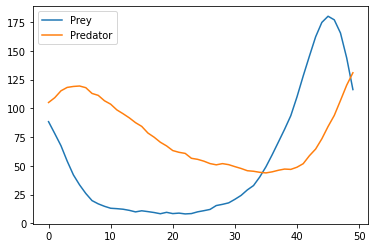

In [19]:
# Instantiate Model
ϵ = 1000
LV = LotkaVolterra(r0, f0, S, δ, σr, σf, mi, si, ϵ)
ystar  = LV.generate_data(z)
LV.set_ystar(ystar)

# Plot prey and predator populations
fig, ax = plt.subplots()
ax.plot(ystar[::2], label='Prey')
ax.plot(ystar[1::2], label='Predator')
ax.legend()
plt.show()

## Hug, $\epsilon=1000$, $T=1$

AttributeError: 'LotkaVolterra' object has no attribute 'ystar_before_ss'

In [5]:
# Hug/Thug settings
T = 1.0
B = 5
N = 10000
α = 0.0
q = MVN(zeros(d), eye(d))

In [6]:
samples, acceptances = HugTangentialMultivariate(ξ0, T, B, N, α, q, LV.log_abc_posterior, LV.J, method='linear')

NameError: name 'ξ0' is not defined

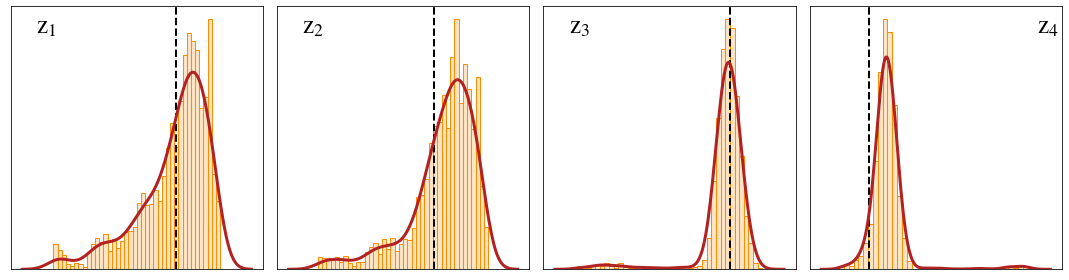

In [645]:
SMOOTH = 0.3
LW = 3
y_pos = 0.9
N_BINS = 40
rc('font',**{'family':'STIXGeneral'})
LABELS = ["$\mathregular{z_1}$", "$\mathregular{z_2}$", "$\mathregular{z_3}$", "$\mathregular{z_4}$"]


fig, ax = plt.subplots(ncols=4, figsize=(15, 4))
for i in range(4):
    _ = ax[i].hist(exp(si*samples[:, i] + mi), bins=N_BINS, density=True, color='bisque', edgecolor='darkorange')
    _ = sns.kdeplot(exp(si*samples[:, i] + mi), bw_method=SMOOTH, lw=LW, ax=ax[i], color='firebrick', zorder=10)
    ax[i].axvline(z[i], color='k', ls='--', lw=2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel("")
    x_pos = 0.9 if i == 3 else 0.1
    ax[i].text(x_pos, y_pos, LABELS[i], transform=ax[i].transAxes, fontsize=25, fontfamily='STIXGeneral')
plt.tight_layout()
plt.show()

In [646]:
acceptances.mean()*100

54.81

# Same but $\epsilon=100$

In [7]:
ϵ = 100
LV = LotkaVolterra(r0, f0, S, δ, σr, σf, mi, si, ϵ)
ystar  = LV.generate_data(z)
LV.set_ystar(ystar)
ξ0 = LV.find_point_on_manifold(max_iter=5000, tol=1e-12, use_jacobian=True)

AttributeError: 'LotkaVolterra' object has no attribute 'ystar_before_ss'

In [648]:
samples, acceptances = HugTangentialMultivariate(ξ0, T, B, N, α, q, LV.log_abc_posterior, LV.J, method='linear')

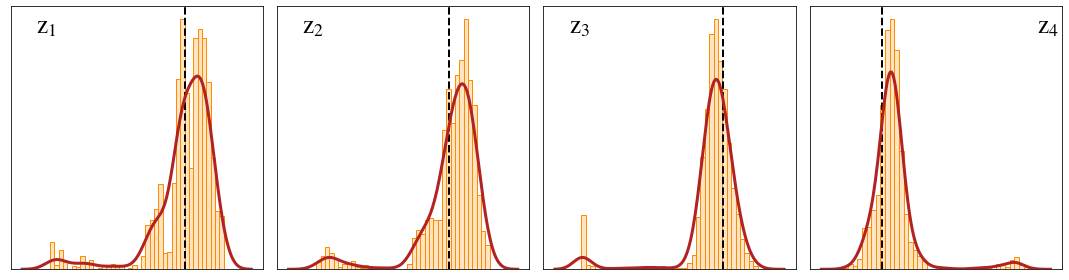

In [649]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 4))
for i in range(4):
    _ = ax[i].hist(exp(si*samples[:, i] + mi), bins=N_BINS, density=True, color='bisque', edgecolor='darkorange')
    _ = sns.kdeplot(exp(si*samples[:, i] + mi), bw_method=SMOOTH, lw=LW, ax=ax[i], color='firebrick', zorder=10)
    ax[i].axvline(z[i], color='k', ls='--', lw=2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel("")
    x_pos = 0.9 if i == 3 else 0.1
    ax[i].text(x_pos, y_pos, LABELS[i], transform=ax[i].transAxes, fontsize=25, fontfamily='STIXGeneral')
plt.tight_layout()
plt.show()

# Same but $\epsilon=10$

In [658]:
ϵ = 10
LV = LotkaVolterra(r0, f0, S, δ, σr, σf, mi, si, ϵ)
ystar  = LV.generate_data(z)
LV.set_ystar(ystar)
ξ0 = LV.find_point_on_manifold(max_iter=5000, tol=1e-12, use_jacobian=False)

In [659]:
samples, acceptances = HugTangentialMultivariate(ξ0, T, B, N, α, q, LV.log_abc_posterior, LV.J, method='linear')

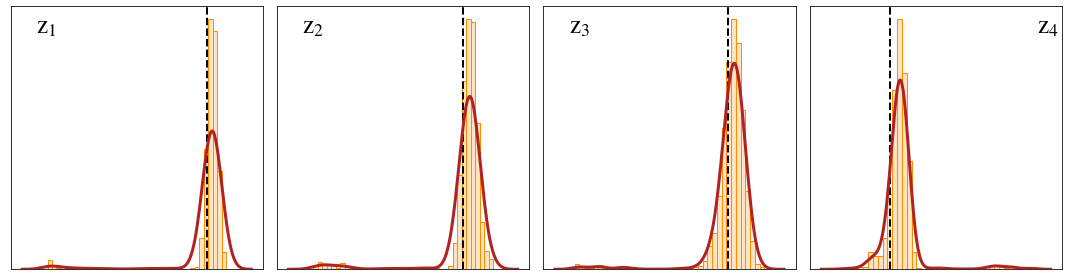

In [660]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 4))
for i in range(4):
    _ = ax[i].hist(exp(si*samples[:, i] + mi), bins=N_BINS, density=True, color='bisque', edgecolor='darkorange')
    _ = sns.kdeplot(exp(si*samples[:, i] + mi), bw_method=SMOOTH, lw=LW, ax=ax[i], color='firebrick', zorder=10)
    ax[i].axvline(z[i], color='k', ls='--', lw=2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel("")
    x_pos = 0.9 if i == 3 else 0.1
    ax[i].text(x_pos, y_pos, LABELS[i], transform=ax[i].transAxes, fontsize=25, fontfamily='STIXGeneral')
plt.tight_layout()
plt.show()

# Same but $\epsilon=1.0$

In [665]:
ϵ = 1
LV = LotkaVolterra(r0, f0, S, δ, σr, σf, mi, si, ϵ)
ystar  = LV.generate_data(z)
LV.set_ystar(ystar)
ξ0 = LV.find_point_on_manifold(max_iter=5000, tol=1e-12, use_jacobian=True)

In [666]:
samples, acceptances = HugTangentialMultivariate(ξ0, T, B, N, α, q, LV.log_abc_posterior, LV.J, method='linear')

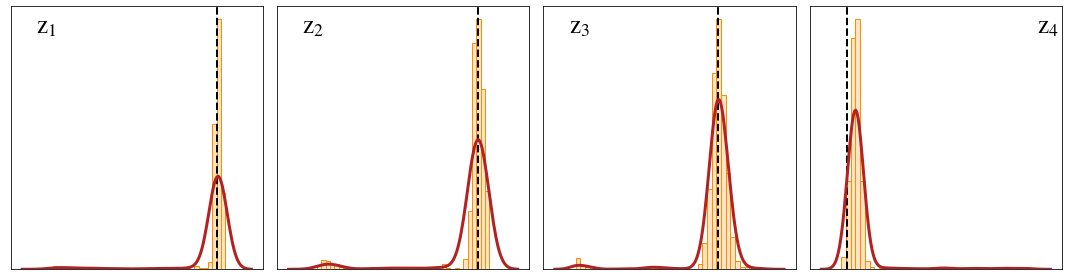

In [667]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 4))
for i in range(4):
    _ = ax[i].hist(exp(si*samples[:, i] + mi), bins=N_BINS, density=True, color='bisque', edgecolor='darkorange')
    _ = sns.kdeplot(exp(si*samples[:, i] + mi), bw_method=SMOOTH, lw=LW, ax=ax[i], color='firebrick', zorder=10)
    ax[i].axvline(z[i], color='k', ls='--', lw=2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel("")
    x_pos = 0.9 if i == 3 else 0.1
    ax[i].text(x_pos, y_pos, LABELS[i], transform=ax[i].transAxes, fontsize=25, fontfamily='STIXGeneral')
plt.tight_layout()
plt.show()

# $\epsilon=0.1$ with Thug 0.9

In [680]:
ϵ = 0.1
LV = LotkaVolterra(r0, f0, S, δ, σr, σf, mi, si, ϵ)
ystar  = LV.generate_data(z)
LV.set_ystar(ystar)
ξ0 = LV.find_point_on_manifold(max_iter=5000, tol=1e-12, use_jacobian=True)

In [682]:
α = 0.9

In [683]:
samples, acceptances = HugTangentialMultivariate(ξ0, T, B, N, α, q, LV.log_abc_posterior, LV.J, method='linear')

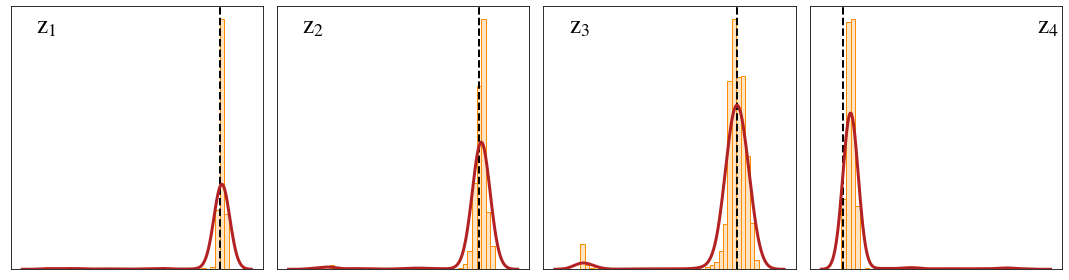

In [684]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 4))
for i in range(4):
    _ = ax[i].hist(exp(si*samples[:, i] + mi), bins=N_BINS, density=True, color='bisque', edgecolor='darkorange')
    _ = sns.kdeplot(exp(si*samples[:, i] + mi), bw_method=SMOOTH, lw=LW, ax=ax[i], color='firebrick', zorder=10)
    ax[i].axvline(z[i], color='k', ls='--', lw=2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel("")
    x_pos = 0.9 if i == 3 else 0.1
    ax[i].text(x_pos, y_pos, LABELS[i], transform=ax[i].transAxes, fontsize=25, fontfamily='STIXGeneral')
plt.tight_layout()
plt.show()

In [685]:
acceptances.mean()*100

4.92

# $\epsilon=0.1$ with Thug 0.99

In [686]:
ϵ = 0.1
LV = LotkaVolterra(r0, f0, S, δ, σr, σf, mi, si, ϵ)
ystar  = LV.generate_data(z)
LV.set_ystar(ystar)
ξ0 = LV.find_point_on_manifold(max_iter=5000, tol=1e-12, use_jacobian=True)

In [687]:
α = 0.99

In [688]:
samples, acceptances = HugTangentialMultivariate(ξ0, T, B, N, α, q, LV.log_abc_posterior, LV.J, method='linear')

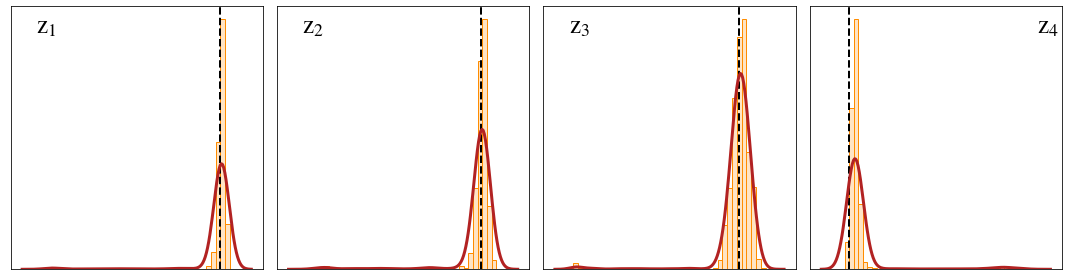

In [689]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 4))
for i in range(4):
    _ = ax[i].hist(exp(si*samples[:, i] + mi), bins=N_BINS, density=True, color='bisque', edgecolor='darkorange')
    _ = sns.kdeplot(exp(si*samples[:, i] + mi), bw_method=SMOOTH, lw=LW, ax=ax[i], color='firebrick', zorder=10)
    ax[i].axvline(z[i], color='k', ls='--', lw=2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel("")
    x_pos = 0.9 if i == 3 else 0.1
    ax[i].text(x_pos, y_pos, LABELS[i], transform=ax[i].transAxes, fontsize=25, fontfamily='STIXGeneral')
plt.tight_layout()
plt.show()

In [690]:
acceptances.mean()*100

6.87

# Same but now using smaller $T$

In [691]:
ϵ = 0.1
LV = LotkaVolterra(r0, f0, S, δ, σr, σf, mi, si, ϵ)
ystar  = LV.generate_data(z)
LV.set_ystar(ystar)
ξ0 = LV.find_point_on_manifold(max_iter=5000, tol=1e-12, use_jacobian=True)

In [692]:
α = 0.99
T = 0.1
N = 100000

In [693]:
samples, acceptances = HugTangentialMultivariate(ξ0, T, B, N, α, q, LV.log_abc_posterior, LV.J, method='linear')

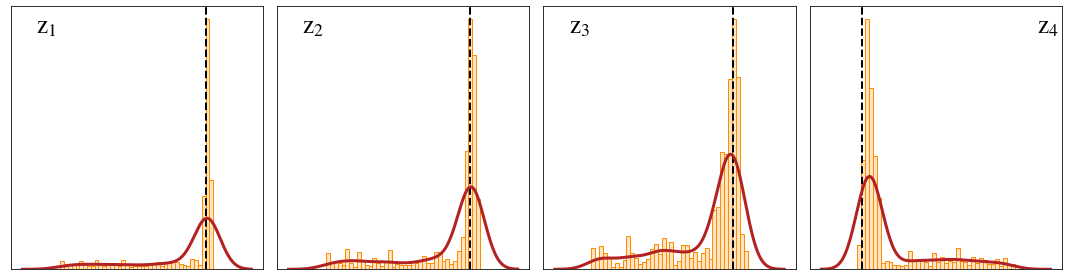

In [694]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 4))
for i in range(4):
    _ = ax[i].hist(exp(si*samples[:, i] + mi), bins=N_BINS, density=True, color='bisque', edgecolor='darkorange')
    _ = sns.kdeplot(exp(si*samples[:, i] + mi), bw_method=SMOOTH, lw=LW, ax=ax[i], color='firebrick', zorder=10)
    ax[i].axvline(z[i], color='k', ls='--', lw=2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel("")
    x_pos = 0.9 if i == 3 else 0.1
    ax[i].text(x_pos, y_pos, LABELS[i], transform=ax[i].transAxes, fontsize=25, fontfamily='STIXGeneral')
plt.tight_layout()
plt.show()

# Summary Statistics

In [10]:
ϵ = 1000
LV = LotkaVolterra(r0, f0, S, δ, σr, σf, mi, si, ϵ, summary_stats=True)
ystar  = LV.generate_data(z)
LV.set_ystar(ystar)
ξ0 = LV.find_point_on_manifold(max_iter=5000, tol=1e-12, use_jacobian=True)

In [11]:
α = 0.9
T = 1.0

In [12]:
samples, acceptances = HugTangentialMultivariate(ξ0, T, B, N, α, q, LV.log_abc_posterior, LV.J, method='linear')

KeyboardInterrupt: 

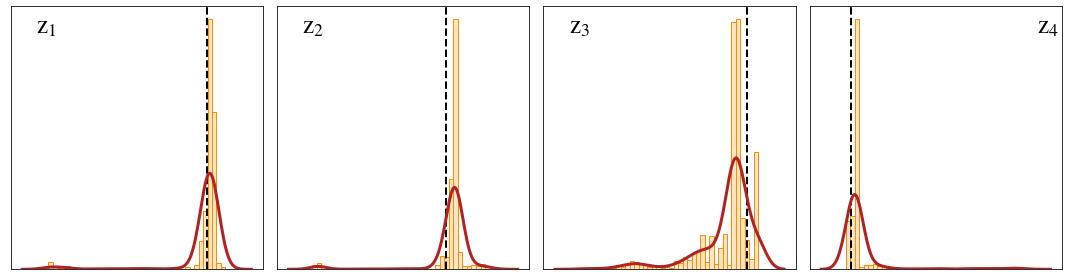

In [836]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 4))
for i in range(4):
    _ = ax[i].hist(exp(si*samples[:, i] + mi), bins=N_BINS, density=True, color='bisque', edgecolor='darkorange')
    _ = sns.kdeplot(exp(si*samples[:, i] + mi), bw_method=SMOOTH, lw=LW, ax=ax[i], color='firebrick', zorder=10)
    ax[i].axvline(z[i], color='k', ls='--', lw=2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel("")
    x_pos = 0.9 if i == 3 else 0.1
    ax[i].text(x_pos, y_pos, LABELS[i], transform=ax[i].transAxes, fontsize=25, fontfamily='STIXGeneral')
plt.tight_layout()
plt.show()